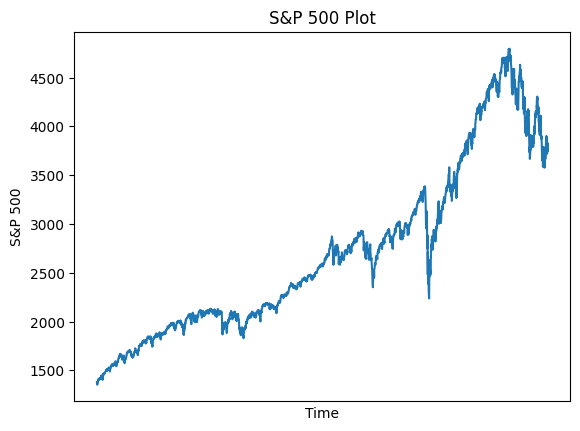

In [58]:

from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def basic_plot(to_plot):
    plt.plot(to_plot)
    plt.xlabel("Time")
    plt.ylabel("S&P 500")
    plt.title("S&P 500 Plot")
    plt.gca().get_xaxis().set_ticks([])
    plt.show()

dataset:pd.DataFrame = pd.read_csv("sp500_index.csv")
dataset_exog:pd.DataFrame = pd.read_csv("sp500_stocks.csv")
companies = ["AAPL", "MSFT", "AMZN", "BRK-B", "JNJ", "JPM", "XOM",  "GOOG", "GOOGL"]
dataset_exog = dataset_exog[dataset_exog['Symbol'].isin(companies)]
dataset_exog['Date'] = pd.to_datetime(dataset_exog['Date'])
dataset_exog = dataset_exog[dataset_exog['Date'] >= datetime(year = 2012,month = 11,day = 12)]
exogenous = dataset_exog[['Date', 'Symbol', 'Close']].dropna()
# Ripulire il dataset da valori nulli e simili
dataset = dataset.dropna()
#dataset = dataset.interpolate()
dataset.columns = ['data', 'sp500']
dataset['data'] = pd.to_datetime(dataset['data'])
dataset = dataset.set_index('data')
exogenous = exogenous.set_index('Date')
exogenous = exogenous.pivot_table(index=['Date'], 
            columns=['Symbol'], values='Close').fillna(0)
exogenous.drop(index=exogenous.index[-1],axis=0,inplace=True)
# Plot per visualizzare il dataset
#plt.plot(dataset['data'].dt.year.unique(), dataset.groupby(dataset['data'].dt.year)['sp500'].mean())
basic_plot(dataset.sp500)

In [59]:
print(dataset)
print(dataset_exog)

              sp500
data               
2012-11-12  1380.03
2012-11-13  1374.53
2012-11-14  1355.49
2012-11-15  1353.33
2012-11-16  1359.88
...             ...
2022-11-03  3719.89
2022-11-04  3770.55
2022-11-07  3806.80
2022-11-08  3828.11
2022-11-09  3748.57

[2517 rows x 1 columns]
              Date Symbol   Adj Close       Close        High         Low  \
75194   2012-11-12  GOOGL   16.664164   16.664164   16.761763   16.538288   
75195   2012-11-13  GOOGL   16.492743   16.492743   16.706707   16.472221   
75196   2012-11-14  GOOGL   16.330080   16.330080   16.571072   16.278778   
75197   2012-11-15  GOOGL   16.197699   16.197699   16.516518   16.113613   
75198   2012-11-16  GOOGL   16.195696   16.195696   16.341843   15.915916   
...            ...    ...         ...         ...         ...         ...   
1029679 2022-11-04   MSFT  221.389999  221.389999  221.589996  213.429993   
1029680 2022-11-07   MSFT  227.869995  227.869995  228.410004  221.279999   
1029681 2022-11-08   M

              sp500
data               
2012-11-12  1380.03
2012-11-13  1374.53
2012-11-14  1355.49
2012-11-15  1353.33
2012-11-16  1359.88
...             ...
2022-11-03  3719.89
2022-11-04  3770.55
2022-11-07  3806.80
2022-11-08  3828.11
2022-11-09  3748.57

[2517 rows x 1 columns]


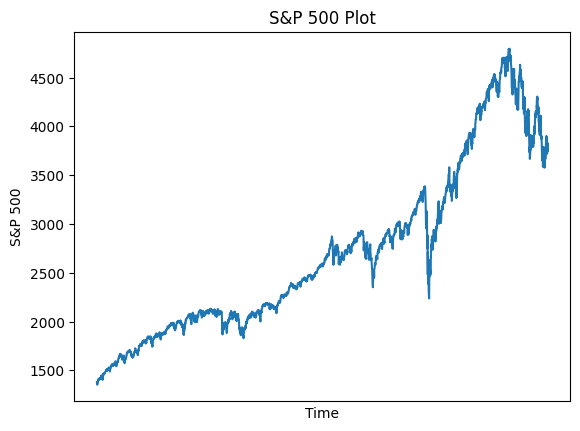

In [60]:
dataset = dataset
print(dataset)
basic_plot(dataset.sp500)

In [61]:
# ADF test per capire se la serie è stazionaria o meno
adf_test_results = adfuller(dataset.sp500)

# Controllare il p-value per del risultato per capire se la serie sia stazionaria
print(f"ADF Statistic: {adf_test_results[0]}")
print(f"p-value: {adf_test_results[1]}")

ADF Statistic: -1.0212412028824258
p-value: 0.7454384431334123


              sp500
data               
2012-11-12  1380.03
2012-11-13  1374.53
2012-11-14  1355.49
2012-11-15  1353.33
2012-11-16  1359.88
...             ...
2022-11-03  3719.89
2022-11-04  3770.55
2022-11-07  3806.80
2022-11-08  3828.11
2022-11-09  3748.57

[2517 rows x 1 columns]
            sp500
data             
2012-11-13  -5.50
2012-11-14 -19.04
2012-11-15  -2.16
2012-11-16   6.55
2012-11-19  27.01
...           ...
2022-11-03 -39.80
2022-11-04  50.66
2022-11-07  36.25
2022-11-08  21.31
2022-11-09 -79.54

[2516 rows x 1 columns]


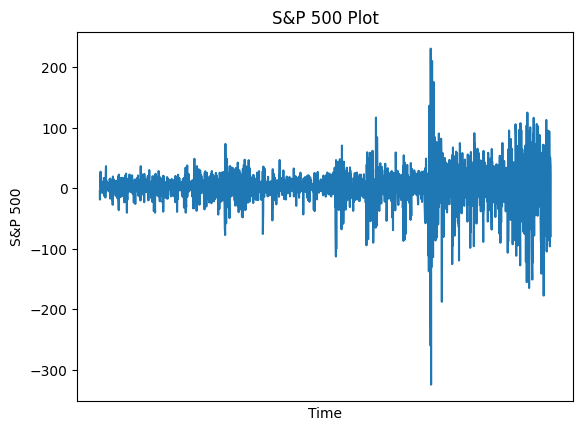

In [62]:
# La serie non è stazionaria
print(dataset)
differentiated = dataset.copy()
differentiated.sp500=differentiated.sp500.diff()
differentiated=differentiated.dropna()
print(differentiated)
basic_plot(differentiated.sp500)

In [63]:
# Si controlla se la nuova serie differenziata
adf_test_results = adfuller(differentiated.sp500)

print(f"ADF Statistic: {adf_test_results[0]}")
print(f"p-value: {adf_test_results[1]}")

# Il p-value è basso --> la serie è stazionaria con una sola differenziazione
d=1

ADF Statistic: -10.568001065894553
p-value: 7.430229545589398e-19


C:\Users\lorti\PyCharmProjects\datascience\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


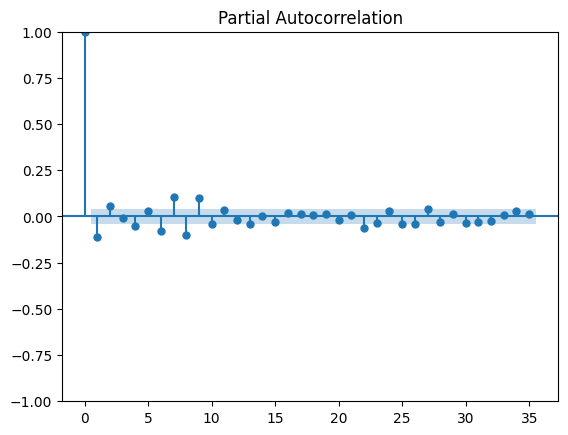

In [64]:
# Ora si controlla l'auto-correlazione parziale
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(differentiated.sp500)
p=1

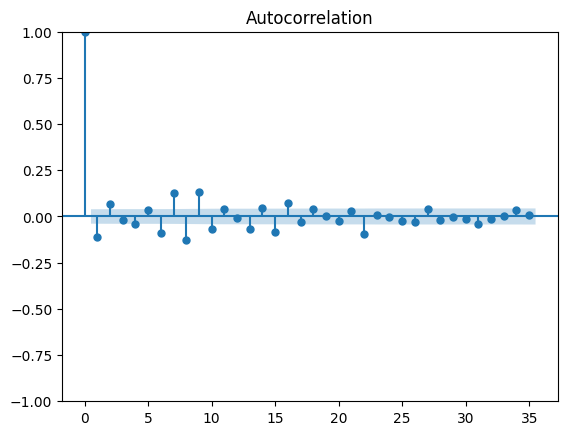

In [65]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(differentiated.sp500)
q=2

In [67]:
# Una volta scelti i parametri si definisce il modello ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
dataset_SARIMAX = dataset.copy()
dataset_SARIMAX.index = pd.DatetimeIndex(dataset_SARIMAX.index).to_period('D') 
exogenous_for_prediction = exogenous.copy()
exogenous_for_prediction.index = pd.DatetimeIndex(exogenous_for_prediction.index).to_period('D') 
model = SARIMAX(dataset_SARIMAX, order=(p,d,q), exog=exogenous_for_prediction)

model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sp500   No. Observations:                 2517
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -9448.777
Date:                Mon, 03 Apr 2023   AIC                          18923.554
Time:                        10:59:57   BIC                          18999.350
Sample:                    11-12-2012   HQIC                         18951.063
                         - 11-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AAPL           4.2508      0.133     31.918      0.000       3.990       4.512
AMZN           1.6216      0.074     22.049      0.000       1.477       1.766
BRK-B         -0.4857      0.070     -6.928      0.0

<Axes: title={'center': 'Residuals'}, xlabel='Date'>

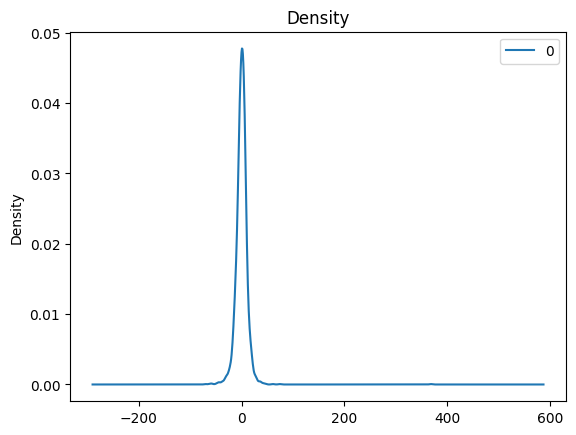

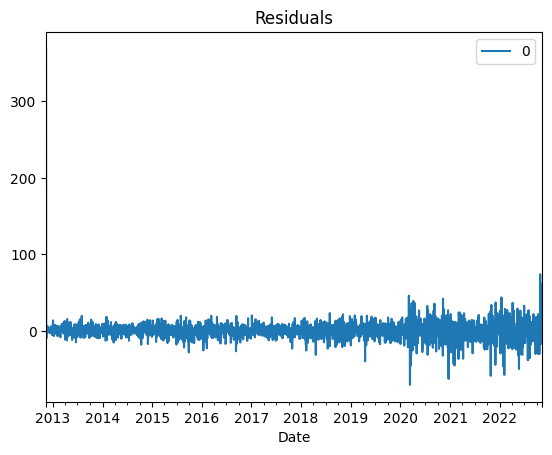

In [31]:
# Si fa il plot dei residui
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde', title="Density")
residuals.plot(title="Residuals")

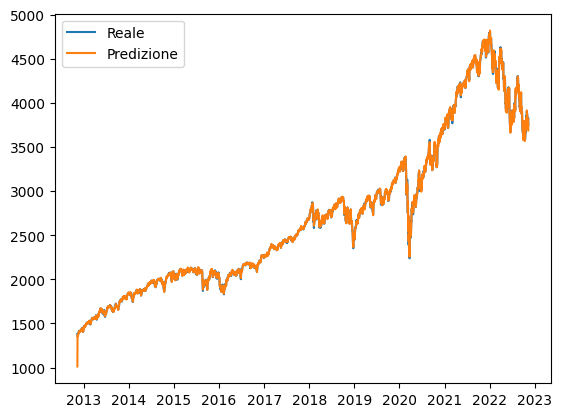

In [32]:
# Si fa la predizione
plt.plot(dataset, label="Reale")
plt.plot(model_fit.predict(dynamic=False), label="Predizione")
plt.legend()
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
train = dataset[:2012]
test = dataset[2012:]


In [86]:
from datetime import date, timedelta

start = date(year=2022, month=11, day=9)
end = date(year=2022, month=12, day=21)

# get list of all days
all_days = [start + timedelta(x) for x in range((end - start).days)]
business_days = list(filter(lambda x: x.weekday()<5, all_days))
print(len(business_days))

30


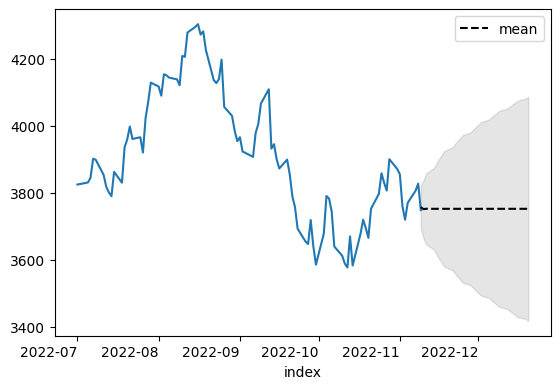

In [50]:
from statsmodels.tsa.arima.model import ARIMA
dataset_ARIMA = dataset.copy()
dataset_ARIMA.index = pd.DatetimeIndex(dataset_ARIMA.index).to_period('D') 
model = ARIMA(dataset_ARIMA, order=(p,d,q))
model_fit=model.fit()
fcasting = model_fit.get_forecast(30).summary_frame()
fig, ax = plt.subplots()
dataset[dataset.index >= datetime(year=2022, month=7, day=1)].sp500.plot(ax=ax)
mean = fcasting["mean"].reset_index(drop=True)
mean = pd.DataFrame({"mean":mean, "index": business_days}).set_index('index')
mean_lower = fcasting["mean_ci_lower"].reset_index(drop=True)
mean_lower = pd.DataFrame({"mean_ci_lower":mean_lower, "index": business_days}).set_index('index')
mean_upper = fcasting["mean_ci_upper"].reset_index(drop=True)
mean_upper = pd.DataFrame({"mean_ci_upper":mean_upper, "index": business_days}).set_index('index')
mean.plot(ax=ax, style='k--')
ax.fill_between(mean.index, mean_lower['mean_ci_lower'], mean_upper['mean_ci_upper'], color='k', alpha=0.1)

In [79]:
from datetime import date, timedelta

start = date(year=2022, month=8, day=17)
end = date(year=2022, month=11, day=10)

# get list of all days
all_days_2 = [start + timedelta(x) for x in range((end - start).days)]
business_days_2 = list(filter(lambda x: x.weekday()<5, all_days_2))
print(len(business_days_2))
print(business_days_2)

60
[datetime.date(2022, 8, 18), datetime.date(2022, 8, 19), datetime.date(2022, 8, 22), datetime.date(2022, 8, 23), datetime.date(2022, 8, 24), datetime.date(2022, 8, 25), datetime.date(2022, 8, 26), datetime.date(2022, 8, 29), datetime.date(2022, 8, 30), datetime.date(2022, 8, 31), datetime.date(2022, 9, 1), datetime.date(2022, 9, 2), datetime.date(2022, 9, 5), datetime.date(2022, 9, 6), datetime.date(2022, 9, 7), datetime.date(2022, 9, 8), datetime.date(2022, 9, 9), datetime.date(2022, 9, 12), datetime.date(2022, 9, 13), datetime.date(2022, 9, 14), datetime.date(2022, 9, 15), datetime.date(2022, 9, 16), datetime.date(2022, 9, 19), datetime.date(2022, 9, 20), datetime.date(2022, 9, 21), datetime.date(2022, 9, 22), datetime.date(2022, 9, 23), datetime.date(2022, 9, 26), datetime.date(2022, 9, 27), datetime.date(2022, 9, 28), datetime.date(2022, 9, 29), datetime.date(2022, 9, 30), datetime.date(2022, 10, 3), datetime.date(2022, 10, 4), datetime.date(2022, 10, 5), datetime.date(2022, 10,

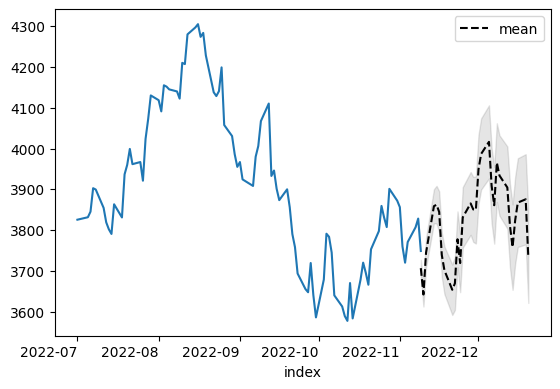

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
dataset_SARIMAX = dataset.copy()
dataset_SARIMAX.index = pd.DatetimeIndex(dataset_SARIMAX.index).to_period('D')
model_sarimax = SARIMAX(dataset_SARIMAX, order=(p,d,q), exog=exogenous_for_prediction, trend='ct')
model_fit = model_sarimax.fit()
fcasting = model_fit.get_forecast(30, exog=exogenous_for_prediction[exogenous.index > datetime(year=2022, month=9, day=28)]).summary_frame()
fig, ax = plt.subplots()
dataset[dataset.index >= datetime(year=2022, month=7, day=1)].sp500.plot(ax=ax)
mean = fcasting["mean"].reset_index(drop=True)
mean = pd.DataFrame({"mean":mean, "index": business_days}).set_index('index')
mean_lower = fcasting["mean_ci_lower"].reset_index(drop=True)
mean_lower = pd.DataFrame({"mean_ci_lower":mean_lower, "index": business_days}).set_index('index')
mean_upper = fcasting["mean_ci_upper"].reset_index(drop=True)
mean_upper = pd.DataFrame({"mean_ci_upper":mean_upper, "index": business_days}).set_index('index')
mean.plot(ax=ax, style='k--')
ax.fill_between(mean.index, mean_lower['mean_ci_lower'], mean_upper['mean_ci_upper'], color='k', alpha=0.1)

In [38]:
test


,data,sp500
2012,2020-11-09,3550.50
2013,2020-11-10,3545.53
2014,2020-11-11,3572.66
2015,2020-11-12,3537.01
2016,2020-11-13,3585.15
...,...,...
2512,2022-11-03,3719.89
2513,2022-11-04,3770.55
2514,2022-11-07,3806.80
2515,2022-11-08,3828.11
